# 1. Loading Data

In [2]:
%matplotlib inline

import numpy
import matplotlib
import matplotlib.pyplot as plt

B = numpy.loadtxt("../Results/B.csv", delimiter=",")  # 149 x 4
C = numpy.loadtxt("../Results/C.csv", delimiter=",")  # 18 x 18
D = numpy.loadtxt("../Results/D.csv", delimiter=",")  # 149 x 24

# 2. Current results

### Data description: 
* 2015-06-05 / 2015-08-02
* 10393828 taxi trips

## Considerations

* To not use the road bed do not changed the results obtained sigficantly, when looking to the with data for all hours of the day. 
* The aumount of taxi trip data used do not affected significantly the results. Maybe they follow a similiar distribution no matter the chosen period?

# 3. Analyzing Complaints' Categories Correlation Matrix

In [3]:
categories = ['Air Condition/Ventilation Equipment', 
              'Alarms',
              'Banging/Pounding', 
              'Barking Dog', 
              'Car/Truck Horn',
              'Car/Truck Music', 
              'Construction Equipment',
              'Construction Before/After Hours', 
              'Engine Idling',
              'Ice Cream Truck', 
              'Jack Hammering', 
              'Lawn Care Equipment',
              'Loud Music/Party', 
              'Loud Talking', 
              'Loud Television',
              'Manufacturing Noise', 
              'Others',
              'Private Carting Noise']

max_corr = numpy.argmax(C)
min_corr = numpy.argmin(C)

print 'dim(C)', numpy.shape(C)  # checking
print 'Max correlation =', numpy.max(C), 'for categories', categories[max_corr/18], '|', categories[max_corr%18]
print 'Min correlation =', numpy.min(C), 'for categories', categories[min_corr/18], '|', categories[min_corr%18]

dim(C) (18, 18)
Max correlation = 1.0 for categories Air Condition/Ventilation Equipment | Air Condition/Ventilation Equipment
Min correlation = 0.0 for categories Air Condition/Ventilation Equipment | Alarms


For a 311 complaint $ns$ (of the $i$th category), we count the complaints of other categories $varphi_j$ ($i \leq j \leq M, j \neq i$) within the distance $\delta$ to $n$. 
Then the correlation between two categories $c_i$ and $c_j$ can be calculated as:    

$$cor(c_i, c_j) = \dfrac{\sum_{ns \in \Psi, ns.c=c_i \mid \varphi_j \mid}}{\mid c_i \mid \dot \mid c_j \mid}$$ with $c_i \neq c_j$.

$$\varphi_j = {ns' \mid dist(ns.l, ns'.l) \leq \delta \wedge ns'.c = c_j}$$

Where $\mid c_i \mid$ and $\mid c_j \mid$ denote the number of  complaints in category $c_i$ and $c_j$ respectively, $\Psi$ is the collection of 311 data.

In [4]:
def fillCorr(complaints_loc, dist):
    """
    Fill the correlation matrix for the Tensor Context Aware Decomposition.
    :param complaints_loc: dictionary {complaint type : [coordinates]}
    :param dist: minimum distance between coordinates to be considered.
    :return: numpy array containing the correlation between each complaint category.
    """
    complaints_loc = collections.OrderedDict(sorted(complaints_loc.items()))  # To maintain an order in a dict
    categories = len(complaints_loc)                                          # Number of different categories

    Z = numpy.ones((categories, categories))

    for index_1, key_1 in enumerate(complaints_loc):
        for index_2, key_2 in enumerate(complaints_loc):  # Forming pairs
            if index_1 != index_2:
                loc_1 = complaints_loc[key_1]  # List of tuples corresponding to coordinates for type *i*
                loc_2 = complaints_loc[key_2]  # List of tuples corresponding to coordinates for type *j*
                sum = 0
                for l1 in loc_1:
                    for l2 in loc_2:
                        p1 = (l1[0], l1[1])
                        p2 = (l2[0], l2[1])
                        if haversine(p1, p2) <= dist:  # Distance between two complaints of types *i* and *j*
                            sum += 1
                mul = float(len(loc_1) * len(loc_2))
                if mul != 0:
                    Z[index_1, index_2] = sum / mul    # Correlation between category *i* and *j*
                else:
                    Z[index_1, index_2] = 0.0

    return Z

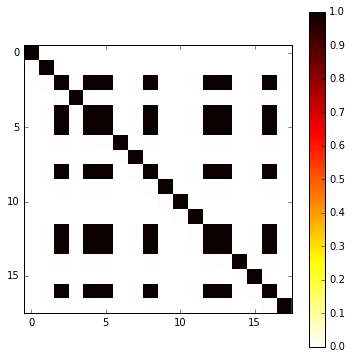

In [5]:
plt.figure(figsize=(6, 6), dpi=200)
fig = plt.imshow(C, cmap=plt.cm.hot_r, interpolation='none')
plt.axes().set_aspect('equal')
plt.colorbar(fig)

Easy to see that the correlation matrix is not good... The distance used was 100. All correlations that are non-zero are 1.0. Changing the distance parameter changed slightly the correlation value, but not the instances that have correlations between each other.

In [13]:
for i in range(0, 15):
    for j in range(i, 15):
        if i!=j and C[i, j] != 0.0:
            print C[i, j], ':', i, j, '-', categories[i%18], '|', categories[j%18]

1.0 : 2 4 - Banging/Pounding | Car/Truck Horn
1.0 : 2 5 - Banging/Pounding | Car/Truck Music
1.0 : 2 8 - Banging/Pounding | Engine Idling
1.0 : 2 12 - Banging/Pounding | Loud Music/Party
1.0 : 2 13 - Banging/Pounding | Loud Talking
1.0 : 4 5 - Car/Truck Horn | Car/Truck Music
1.0 : 4 8 - Car/Truck Horn | Engine Idling
1.0 : 4 12 - Car/Truck Horn | Loud Music/Party
1.0 : 4 13 - Car/Truck Horn | Loud Talking
1.0 : 5 8 - Car/Truck Music | Engine Idling
1.0 : 5 12 - Car/Truck Music | Loud Music/Party
1.0 : 5 13 - Car/Truck Music | Loud Talking
1.0 : 8 12 - Engine Idling | Loud Music/Party
1.0 : 8 13 - Engine Idling | Loud Talking
1.0 : 12 13 - Loud Music/Party | Loud Talking


Now let's check the top significant complaints in the input data (matrix A).

In [9]:
A = numpy.zeros((149, 18, 24))  # 149 x 18 x 24 -- original / sparse
P = numpy.zeros((149, 18, 24))  # 149 x 18 x 24 -- missing values inferred
for t in range(24):
    A[:, :, t] = numpy.loadtxt("../Results/A-"+str(t)+".csv", delimiter=",")
    P[:, :, t] = numpy.loadtxt("../Results/P-"+str(t)+".csv", delimiter=",")   
total_A = numpy.sum(A, axis=(0,2))
total_P = numpy.sum(P, axis=(0,2)) 

print 'dim(total_A)', total_A.shape
print 'dim(total_P)', total_P.shape

top_A = numpy.argpartition(total_A, -8, axis=None)[-8:]
top_P = numpy.argpartition(total_P, -8, axis=None)[-8:]

print 'Top categories for input matrix A:'
sorted([(categories[i], numpy.round(total_A[i])) for i in top_A], key=lambda tup: tup[1])

dim(total_A) (18,)
dim(total_P) (18,)
Top categories for input matrix A:


[('Barking Dog', 0.0),
 ('Car/Truck Horn', 15.0),
 ('Engine Idling', 27.0),
 ('Banging/Pounding', 30.0),
 ('Car/Truck Music', 49.0),
 ('Loud Talking', 122.0),
 ('Others', 278.0),
 ('Loud Music/Party', 376.0)]

In [10]:
print 'Top categories for output matrix P:'
sorted([(categories[i], numpy.round(total_P[i])) for i in top_P], key=lambda tup: tup[1])

Top categories for output matrix P:


[('Alarms', 459.0),
 ('Air Condition/Ventilation Equipment', 460.0),
 ('Car/Truck Horn', 471.0),
 ('Manufacturing Noise', 472.0),
 ('Engine Idling', 480.0),
 ('Construction Equipment', 481.0),
 ('Loud Music/Party', 1036.0),
 ('Others', 1318.0)]

As we can see, there is just one categoried in commom between the input and output matrix (I'm not taking "Others" into account).

# 4. Analyzing Humam Mobility Features Matrix

In [11]:
print 'dim(D)', numpy.shape(D)  # checking
total_dropoffs = numpy.sum(D, axis=1)
print 'dim(total_dropofss)', numpy.shape(total_dropoffs)
top_dropoffs = numpy.argpartition(total_dropoffs, -10, axis=None)[-10:]
print 'Regions with most dropoffs:'
[(i, round(total_dropoffs[i], 2)) for i in top_dropoffs]

dim(D) (149, 24)
dim(total_dropofss) (149,)
Regions with most dropoffs:


[(130, 1.78),
 (10, 1.82),
 (0, 3.71),
 (139, 3.92),
 (121, 6.29),
 (105, 16.05),
 (104, 7.54),
 (8, 9.84),
 (4, 7.36),
 (97, 6.07)]

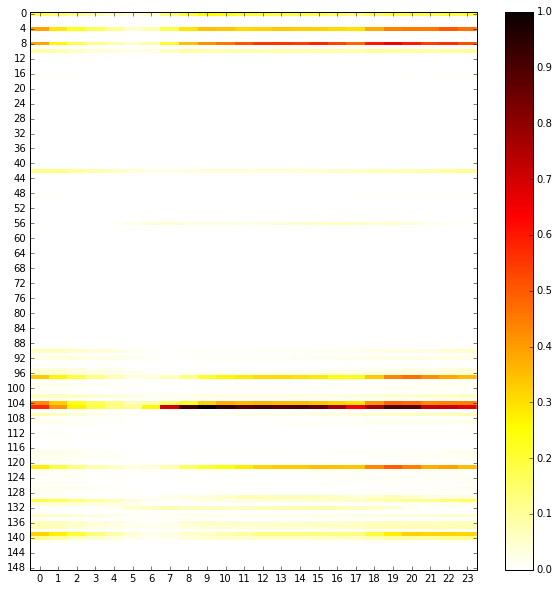

In [12]:
plt.figure(figsize=(10, 10), dpi=200)
fig = plt.imshow(D, cmap=plt.cm.hot_r, interpolation='none', aspect='auto')
plt.yticks(numpy.arange(0, 150, 4))
plt.xticks(numpy.arange(0, 24, 1))
plt.colorbar(fig)

## 5. Analyzing Regions' Features Matrix